<p style="font-size:14pt;text-align:center;">
Pretraining network on pascal VOC.
</p>

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import theano
from theano import tensor as T
import pickle as pk
import re
from copy import deepcopy
import sys

# image processing
from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2hsv, hsv2rgb

import lasagne
from lasagne.layers import Pool2DLayer, Conv2DLayer, dropout, \
    DenseLayer, InputLayer, get_output, get_all_params
    
import bnr_ml.objectdetect.yolo as yolo

import pdb

/Users/colingaudreau/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
Using gpu device 0: GeForce GTX 960 (CNMeM is enabled with initial size: 80.0% of memory, cuDNN not available)
/Library/Python/2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [2]:
with open('/usr/local/python/bnr_ml/data/PascalVOC/annotations.txt', 'rb') as f:
    annotations = pk.load(f)['annotations']

In [3]:
def add_proper_labels(annotations):
    for im in annotations:
        for obj in im:
            if 'car' in obj['label'].lower():
                obj['label'] = 'car'
            elif 'bicycle' in obj['label'].lower():
                obj['label'] = 'bicycle'
            elif 'person' in obj['label'].lower():
                obj['label'] = 'person'
            elif 'bike' in obj['label'].lower():
                obj['label'] = 'bike'
            else:
                print obj

In [4]:
def get_label_counts(annotations):
    counts = np.zeros((4,))
    for im in annotations:
        for obj in im:
            if obj['label'] == 'car':
                counts[0] += 1
            elif obj['label'] == 'bicycle':
                counts[1] += 1
            elif obj['label'] == 'bike':
                counts[2] += 1
            else:
                counts[3] += 1
    return counts

In [5]:
add_proper_labels(annotations)

In [6]:
annotations = np.asarray(annotations)

In [7]:
counts = get_label_counts(annotations)

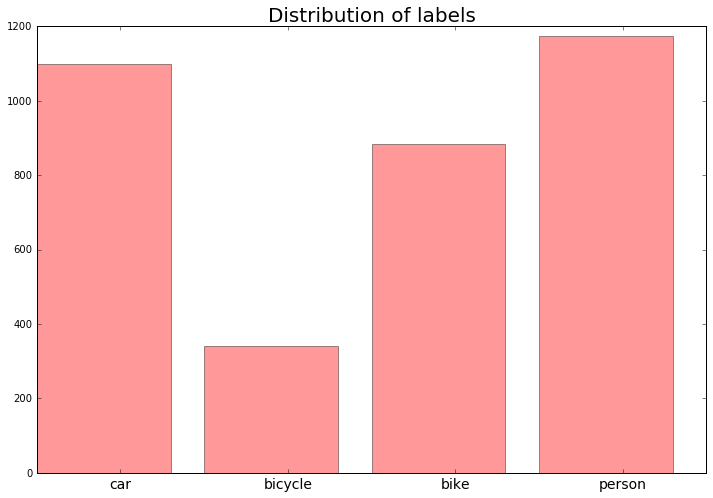

In [8]:
plt.figure(figsize=(12,8))
plt.title('Distribution of labels', fontsize=20)
plt.bar(np.arange(counts.size), counts, color='red', alpha=.4)
plt.xticks(np.arange(counts.size) + .5, ['car', 'bicycle', 'bike', 'person'], fontsize=14)
plt.show()

In [9]:
np.random.seed(1991)

<b>Split the annotations for training and testing, the reason I split by image and not individual object is so that when testing the performance, the network will never have seen any part of the test image.

In [10]:
with open('indices.pkl', 'rb') as f:
    indices = pk.load(f)
    train_idx = indices['train_index']
    test_idx = indices['test_index']

In [11]:
train_annotations = annotations[train_idx]
test_annotations = annotations[test_idx]

In [12]:
class Box(object):
    def __init__(self, xi,yi,xf,yf):
        self.xi = xi
        self.yi = yi
        self.xf = xf
        self.yf = yf
    def iou(self, box):
        isec = self.intersection(box)
        union = self.size() + box.size() - isec.size()
        return isec.size() / union
    def intersection(self, box):
        new_xi = max(self.xi, box.xi)
        new_yi = max(self.yi, box.yi)
        new_xf = min(self.xf, box.xf)
        new_yf = min(self.yf, box.yf)
        if new_xi > new_xf or new_yi > new_yf:
            new_xi, new_yi, new_xf, new_yf = 0., 0., 0., 0.
        return Box(new_xi, new_yi, new_xf, new_yf)
    def size(self):
        return (self.xf - self.xi) * (self.yf - self.yi)
    def width(self):
        return (self.xf - self.xi)
    def height(self):
        return (self.yf - self.yi)
    def copy(self):
        return Box(self.xi, self.yi, self.xf, self.yf)
    def subimage(self, im):
        xi = max(0, int(im.shape[1] * self.xi))
        yi = max(0, int(im.shape[0] * self.yi))
        xf = min(im.shape[1], int(im.shape[1] * self.xf))
        yf = min(im.shape[0], int(im.shape[0] * self.yf))
        return im[yi:yf, xi:xf]
    def round(self):
        self.xi, self.yi, self.xf, self.yf = round(self.xi), round(self.yi), round(self.xf), round(self.yf)
    def __str__(self):
        return '(' + str(self.xi) + ',' + str(self.yi) + ') (' + str(self.xf) + ',' + str(self.yf) + ')'
    def __repr__(self):
        return self.__str__()
    @staticmethod
    def gen_randombox(iou, box, eps=.5):
        angle = 2 * np.pi * np.random.rand()
        delx, dely = eps*np.cos(angle), eps*np.sin(angle)
        new_box = box.copy()
        while new_box.iou(box) > iou:
            new_box.xi += delx
            new_box.yi += dely
            new_box.xf += delx
            new_box.yf += dely
        return new_box

In [13]:
def generate_data_2(annotations, C, max_objs=15, size=(200,200), batch_size=100):
    def reformat_image(im, new_size):
        if im.shape.__len__() == 2:
            im = np.repeat(im.reshape(im.shape + (1,)), 3, axis=2)
        elif im.shape[2] > 3:
            im = im[:,:,:3]
        if im.shape[0] == 0 or im.shape[2] == 0:
            return None
        return resize(im, new_size).swapaxes(2,1).swapaxes(1,0)
    def transform_coord(coord, old_size, new_size):
        coord[[0,2]] *= 1. / old_size[1]
        coord[[1,3]] *= 1. / old_size[0]
        
        if coord[2] >= coord[0]:
            coord[2] -= coord[0]
        else:
            coord[2] = coord[0] - coord[2]
        if coord[3] >= coord[1]:
            coord[3] -= coord[1]
        else:
            coord[3] = coord[1] - coord[3]
        return coord
    def get_num_from_label(label):
        if label == 'car':
            return 0
        elif label == 'bicycle':
            return 1
        elif label == 'bike':
            return 2
        elif label == 'person':
            return 3
        elif label == 'noobj':
            return 4
        else:
            pass
        
    annotations = np.asarray([[deepcopy(obj) for obj in objs] for objs in annotations]) # deep copy annotations

    fake_truth = np.concatenate((np.asarray([-10.,-10.,.01,.01]), np.zeros((C,))))
    
    np.random.shuffle(annotations)
    
    for i in range(0,annotations.shape[0], batch_size):
        Xbatch = np.zeros((batch_size,3) + size)
        ybatch = np.zeros((batch_size, (4 + C) * max_objs))
        
        for j in range(min(batch_size, annotations.shape[0] - i)):
            objs = annotations[i+j]
            im = imread(objs[0]['image'])
            old_size = im.shape
            
            Xbatch[j] = reformat_image(im, size)
            
            for k in range(max_objs):
                if k < objs.__len__():
                    obj = objs[k]
                    coord = np.asarray(obj['p1'] + obj['p2']).astype(theano.config.floatX)
                    coord = transform_coord(coord, old_size, size)
                    ybatch[j,k*(4 + C):k*(4 + C) + 4] = coord
                    ybatch[j,k*(4 + C)+4 + get_num_from_label(obj['label'])] += 1
                else:
                    ybatch[j,k*(4 + C):(k + 1)*(4 + C)] = fake_truth
            
        yield Xbatch[:j+1].astype(theano.config.floatX), ybatch[:j+1].astype(theano.config.floatX)

In [14]:
def generate_data_3(annotations, C, max_objs=15, size=(200,200), batch_size=100, augment=10):
    def reformat_image(im, new_size):
        if im.shape.__len__() == 2:
            im = np.repeat(im.reshape(im.shape + (1,)), 3, axis=2)
        elif im.shape[2] > 3:
            im = im[:,:,:3]
        if im.shape[0] == 0 or im.shape[2] == 0:
            return None
        return resize(im, new_size)
    def transform_coord(coord, old_size, new_size):
        coord[[0,2]] *= 1. / old_size[1]
        coord[[1,3]] *= 1. / old_size[0]
        
        if coord[2] >= coord[0]:
            coord[2] -= coord[0]
        else:
            coord[2] = coord[0] - coord[2]
        if coord[3] >= coord[1]:
            coord[3] -= coord[1]
        else:
            coord[3] = coord[1] - coord[3]
        return coord
    def get_num_from_label(label):
        if label == 'car':
            return 0
        elif label == 'bicycle':
            return 1
        elif label == 'bike':
            return 2
        elif label == 'person':
            return 3
        elif label == 'noobj':
            return 4
        else:
            pass
        
    annotations = np.asarray([[deepcopy(obj) for obj in objs] for objs in annotations]) # deep copy annotations

    fake_truth = np.concatenate((np.asarray([-10.,-10.,.01,.01]), np.zeros((C,))))
    
    np.random.shuffle(annotations)
    
    for num in range(augment):
        for i in range(0,annotations.size, batch_size):
            Xbatch = np.zeros((batch_size,3) + size)
            ybatch = np.zeros((batch_size, (4 + C) * max_objs))

            for j in range(min(batch_size, annotations.size - i)):
                objs = annotations[i+j]
                im = imread(objs[0]['image'])
                old_size = im.shape
                
                old_box = Box(0.,0.,1.,1.)
                iterlap = 1.
                new_width = iterlap + (1. - iterlap) * np.random.rand()
                new_height = iterlap +  (1. - iterlap) * np.random.rand()
                new_xi = (1. - new_width) * np.random.rand()
                new_yi = (1. - new_height) * np.random.rand()
                new_box = Box(
                    new_xi,
                    new_yi,
                    new_width + new_xi,
                    new_height + new_yi
                )
                im = new_box.subimage(im)

                im = reformat_image(im, size)
                
                im = rgb2hsv(im)
                im[:,:,[0,2]] *= (1 + .3 * np.random.rand(1,1,2))
                im = hsv2rgb(im)
                
                Xbatch[j] = im.swapaxes(2,1).swapaxes(1,0)

                for k in range(max_objs):
                    if k < objs.__len__():
                        obj = objs[k]
                        coord = np.asarray(obj['p1'] + obj['p2']).astype(theano.config.floatX)
                        coord = transform_coord(coord, old_size, size)
                        
                        obj_box = Box(coord[0], coord[1], coord[0] + coord[2], coord[1] + coord[3])
                        
                        if new_box.iou(obj_box) > 0.5:
                            coord[0] -= new_box.xi
                            coord[1] -= new_box.yi
                            coord[[0,2]] /= (new_box.xf - new_box.xi)
                            coord[[1,3]] /= (new_box.yf - new_box.yi)
                            ybatch[j,k*(4 + C):k*(4 + C) + 4] = coord
                            ybatch[j,k*(4 + C)+4 + get_num_from_label(obj['label'])] += 1
                        else:
                            ybatch[j,k*(4 + C):(k + 1)*(4 + C)] = fake_truth

                    else:
                        ybatch[j,k*(4 + C):(k + 1)*(4 + C)] = fake_truth

            yield Xbatch[:j+1].astype(theano.config.floatX), ybatch[:j+1].astype(theano.config.floatX)

In [15]:
def generate_data(annotations, C, size=(200,200), batch_size=100):
    '''
    augment: how many times do you want the data to be replicated
    '''
    def get_objects(annotations):
        objs = []
        for im in annotations:
            objs.extend([deepcopy(obj) for obj in im])
        return np.asarray(objs)
    def get_num_from_label(label):
        if label == 'car':
            return 0
        elif label == 'bicycle':
            return 1
        elif label == 'bike':
            return 2
        elif label == 'person':
            return 3
        elif label == 'noobj':
            return 4
        else:
            pass
#             print('This shouldn\'t happen')
    def subsample_objs(objs, obj_idx, size):
        idx = obj_idx[np.random.random_integers(0,obj_idx.size-1, size=(size,))]
        copy_obj = []
        for obj in objs[idx]:
            copy_obj.append(deepcopy(obj))
        return np.asarray(copy_obj)
    def set_label_to_noobj(objs, obj_idx):
        N = np.int_(np.float_(obj_idx.size) / 5)
        idx = np.arange(obj_idx.size)
        np.random.shuffle(idx)
        for obj in objs[obj_idx[idx[:N]]]:
            obj['label']  = 'noobj'
        return objs
    
    # return flat list of objects
    objs = get_objects(annotations)
    
    # get number from label
    labels = np.asarray([get_num_from_label(obj['label']) for obj in objs])
    
    idx = np.arange(labels.size)
    idx_car = idx[labels==0]
    idx_bicycle = idx[labels==1]
    idx_bike = idx[labels==2]
    idx_person = idx[labels==3]
        
    max_labels = np.max([idx_car.size, idx_bicycle.size, idx_bike.size, idx_person.size])
    
    # get subsamples to get equal number of classes
    new_car = subsample_objs(objs, idx_car, max_labels - idx_car.size)
    new_bicycle = subsample_objs(objs, idx_bicycle, max_labels - idx_bicycle.size)
    new_bike = subsample_objs(objs, idx_bike, max_labels - idx_bike.size)
    new_person = subsample_objs(objs, idx_person, max_labels - idx_person.size)
    
    # add new samples
    objs = np.concatenate((objs, new_car, new_bicycle, new_bike, new_person))
    
    np.random.shuffle(objs)
    
    cnt = 0
    while cnt < objs.size:
        Xbatch = np.zeros((batch_size, 3) + size)
        ybatch = np.zeros((batch_size, 4 + C))
        batch_cnt = 0
        for j in range(batch_size):
            if cnt < objs.size:
                obj = objs[cnt]
                im = imread(obj['image'])
                im = im.astype(theano.config.floatX) / 255
                xscale, yscale = np.float_(size[1]) / im.shape[1], np.float_(size[0]) / im.shape[0]
#                 pdb.set_trace()
                coord = np.asarray(obj['p1'] + obj['p2']).astype(theano.config.floatX)
                coord[[0,2]] *= (xscale / 200)
                coord[[1,3]] *= (yscale / 200)
                if coord[2] >= coord[0]:
                    coord[2] -= coord[0]
                else:
                    coord[2] = coord[0] - coord[2]
                if coord[3] >= coord[1]:
                    coord[3] -= coord[1]
                else:
                    coord[3] = coord[1] - coord[3]
                    
                if coord[2] < 0 or coord[3] < 0:
                    print image
                    
                if im.shape.__len__() == 2:
                    im = im.reshape(im.shape + (1,))
                    im = np.concatenate((im, im, im), axis=2)
                elif im.shape[2] == 4:
                    im = im[:,:,:3]
                if not (im.shape[0] == 0 or im.shape[1] == 0):
                    im = resize(im, size).swapaxes(2,1).swapaxes(1,0)
                    Xbatch[batch_cnt] = im
                    ybatch[batch_cnt, :4] =  coord
                    ybatch[batch_cnt, 4 + get_num_from_label(obj['label'])] += 1
                    batch_cnt += 1
            cnt += 1
        if batch_cnt < batch_size - 1:
            Xbatch, ybatch = Xbatch[:batch_cnt], ybatch[:batch_cnt]
        yield Xbatch.astype(theano.config.floatX), ybatch.astype(theano.config.floatX)

<b>Now we define the net for recognition.</b>

In [16]:
S = (7,7)
B = 2
C = 4

In [17]:
num_epochs = 1000
batch_size = 50

In [ ]:
# Xtest,ytest = [t for t in generate_data_2(train_annotations[:1], C, batch_size=batch_size)][0]
Xtest, ytest = theano.shared(Xtest), theano.shared(ytest)

In [208]:
net = {}
net['input'] = InputLayer((None,3,200,200), input_var=None)
net['conv1'] = Conv2DLayer(net['input'], 16, (3,3))
net['conv2'] = Conv2DLayer(net['conv1'], 16, (3,3))
net['pool1'] = Pool2DLayer(net['conv2'], (2,2))
net['conv3'] = Conv2DLayer(net['pool1'], 32, (3,3))
net['conv4'] = Conv2DLayer(net['conv3'], 32, (3,3))
net['pool2'] = Pool2DLayer(net['conv4'], (2,2))
net['conv5'] = Conv2DLayer(net['pool2'], 64, (3,3))
net['conv6'] = Conv2DLayer(net['conv5'], 64, (3,3))
net['conv7'] = Conv2DLayer(net['conv6'], 64, (3,3))
net['pool3'] = Pool2DLayer(net['conv7'], (2,2))
net['conv8'] = Conv2DLayer(net['pool3'], 128, (3,3))
net['conv9'] = Conv2DLayer(net['conv8'], 128, (3,3))
net['conv10'] = Conv2DLayer(net['conv9'], 128, (3,3))
net['pool4'] = Pool2DLayer(net['conv10'], (2,2))


net['dense1'] = DenseLayer(dropout(net['pool4'], p=.5), 2048)
net['dense2'] = DenseLayer(dropout(net['dense1'], p=.2), (2 * 5 + 4) * (7*7), nonlinearity=None)
net['output'] = DenseLayer(dropout(net['dense2'], p=0), 5, nonlinearity=lasagne.nonlinearities.softmax)

<b>Load pre-trained weights</b>

In [121]:
load_pretrained = True
if load_pretrained:
    with open('pretrained_weights.pkl', 'rb') as f:
        weights = pk.load(f)
        lasagne.layers.set_all_param_values(net['output'], weights)

<b>Add extra layers to network for detection</b>

In [209]:
net['output'] = net['dense2']
# net['output'] = DenseLayer(dropout(net['dense1'], p=.0), (B * 5 + C) * S[0]*S[1])

In [210]:
load_weights = True
if load_weights:
    with open('yolo_weights.pkl', 'rb') as f:
        weights = pk.load(f)
        lasagne.layers.set_all_param_values(net['output'], weights)

<b>Train the network

In [211]:
reload(yolo)

<module 'bnr_ml.objectdetect.yolo' from '/usr/local/python/bnr_ml/objectdetect/yolo.pyc'>

In [212]:
yl = yolo.YoloObjectDetector(net, (None, 3, 200, 200), C, S, B) 

cost = yl._get_cost_optim_multi(yl.output, ytest, S, B, C)

In [386]:
train_loss, test_loss = yl.train(
    generate_data_3(train_annotations, C, batch_size=batch_size, augment=5),
    generate_data_2(test_annotations, C, batch_size=batch_size),
    lr=1e-6,
    epochs=num_epochs
)

Getting cost...
> /usr/local/python/bnr_ml/objectdetect/yolo.py(255)_get_cost_optim_multi()
-> return cost, [iou, obj_in_cell_and_resp, conf_is_zero, obj_in_cell_and_resp, cell_intersects]
(Pdb) c
> /usr/local/python/bnr_ml/objectdetect/yolo.py(255)_get_cost_optim_multi()
-> return cost, [iou, obj_in_cell_and_resp, conf_is_zero, obj_in_cell_and_resp, cell_intersects]
(Pdb) c
Creating cost variable took 1.8531 seconds
Compiling...


  0%|          | 0/1000 [00:00<?, ?it/s]

Compiling functions took 27.7879 seconds
Beginning training...
5.21860900879
6.6293182373
4.77047790527
5.8672644043
4.82679901123
4.39969360352
5.35984619141
4.3001940918
5.02348358154
4.21653717041
5.76715087891
4.78721466064
5.0736907959
4.40211364746
4.46528381348
5.13161193848
3.74897796631
4.17703857422
4.54667327881
4.6907208252
5.66903869629
4.9021383667
4.82219238281
5.29112182617
4.96520721436
4.55679870605
4.72121459961
4.4296182251
4.29083343506
5.20111938477
6.44517944336
4.60303497314
4.84958068848
4.5309576416
4.44766937256
4.36817103795
4.65972106934
6.41927368164
4.04673217773
5.21135131836
5.37347290039
4.00224731445
4.82140869141
4.33991821289
4.89658569336
3.68044769287
5.37377319336
4.51862457275
5.47315429688
4.20959106445
4.3364440918
5.13115234375
3.60326477051
3.78249847412
4.35267608643
4.14572052002
5.8937097168
4.58823059082
4.50701721191
4.8139553833
4.99419128418
4.38741149902
4.44182189941
4.29642883301
4.02851135254
5.11600952148
5.02366577148
4.30543731

  0%|          | 1/1000 [12:51<214:07:54, 771.65s/it]

Epoch 0
------
Train Loss: 4.6045, Test Loss: 11.7016
4.23325897217
6.16862304688
3.78825927734
5.23904663086
4.17350158691
3.58023895264
4.27267242432
3.8072644043
4.52186096191
3.46673278809
5.10467590332
4.29046600342
4.33599121094
3.85362731934
3.50688354492
4.75993682861
3.36514282227
3.33593109131
4.203699646
3.9476159668
5.60903442383
4.55575195313
4.67201568604
5.09290710449
4.53640136719
4.12833312988
4.42271240234
4.07497131348
3.85889129639
4.68124938965
5.28630249023
4.1132598877
4.49206817627
4.12178833008
4.25172210693
4.0123840332
4.19152709961
6.08352233887
3.69360900879
4.80183868408
4.70369812012
3.39338989258
4.10928283691
3.80586791992
4.44161621094
3.1955166626
5.24993652344
3.92998046875
4.89543487549
3.85027679443
3.93876831055
4.60166320801
3.24987548828
3.33324951172
4.12821044922
3.93267364502
5.09075317383
4.24938964844
4.01968261719
4.49069793701
4.45974121094
4.1041003418
4.07906677246
4.03814147949
3.66827453613
4.76224700928
4.53300537109
4.01084472656
6.

  0%|          | 2/1000 [15:11<161:23:57, 582.20s/it]

Epoch 1
------
Train Loss: 4.2102, Test Loss: 11.7374
3.79126159668
6.03321044922
3.61641082764
5.24616943359
4.02425628662
3.16810119629
3.77749816895
3.64677490234
4.2404019165
3.14403930664
4.80849151611
4.11430847168
3.79722106934
3.57980010986
3.22370727539
4.321640625
2.95945770264
2.9874130249
3.91950256348
3.70821960449
4.91690093994
4.1813458252
4.15382446289
4.60793670654
4.41705688477
4.07518371582
4.12142242432
3.95534667969
3.64704986572
4.58740478516
5.2027923584
4.05909454346
4.20963378906
3.95125366211
3.91552185059
3.68882097517
3.93471496582
5.68001403809
3.77864624023
4.77261383057
4.33534240723
3.12172607422
3.82342254639
3.65602172852
4.16429870605
2.91720123291
5.05243621826
3.70977142334
4.55210510254
3.58198364258
3.38935211182
4.4047366333
2.9435043335
3.14802429199
3.68946624756
3.59583374023
5.00245727539
3.95370391846
3.63834594727
4.22472473145
4.36698150635
3.89236450195
3.95446258545
3.87567016602
3.37513183594
4.39727416992
4.33748291016
3.87735046387
6.

  0%|          | 3/1000 [17:31<124:30:24, 449.57s/it]

Epoch 2
------
Train Loss: 3.9954, Test Loss: 11.8236
3.86305541992
5.58208984375
3.42359100342
4.923934021
3.68474151611
2.9876385498
3.55079101563
3.57887451172
4.08635101318
2.76843902588
4.59372589111
3.66376312256
3.84110351562
3.27293945312
3.09737304688
4.17124755859
2.77731506348
2.84993591309
3.68840118408
3.68063995361
4.75498748779
4.12722991943
3.87008605957
4.40822021484
4.4680090332
3.90510314941
4.04642791748
3.78470336914
3.34607788086
4.57895507813
4.97250091553
3.9643560791
4.20568359375
4.0233102417
3.86247314453
3.65154876709
3.76784912109
5.79053283691
3.59985351562
4.5317779541
3.99011383057
2.94787017822
3.48188568115
3.45137481689
4.05346801758
2.72950195313
4.84411682129
3.61233581543
4.44606658936
3.71096862793
3.20310302734
4.23686828613
2.81762298584
3.03590148926
3.69407012939
3.52251403809
4.80798828125
3.83463348389
3.62821716309
4.15844848633
4.42898712158
3.81977203369
3.80502288818
3.65687744141
3.49971343994
4.24713226318
4.00524536133
3.73356628418
5

  0%|          | 4/1000 [19:51<98:41:36, 356.72s/it] 

Epoch 3
------
Train Loss: 3.8583, Test Loss: 11.8687
3.7197064209
5.73682067871
3.47701477051
4.69755004883
3.59873199463
2.84323730469
3.43440673828
3.62370910645
4.09702728271
2.88533782959
4.56231994629
3.57198608398
3.56545593262
3.53408752441
3.03313110352
4.12372131348
2.74001098633
2.65439086914
3.56572509766
3.48358337402
4.56894287109
3.96200683594
3.63237854004
4.33076324463
4.3337512207
3.95642944336
3.99197387695
3.56647155762
3.3470715332
4.43096862793
4.84532165527
3.88552307129
3.99198608398
3.7397833252
3.7618572998
3.51351841518
3.59227966309
5.64954833984
3.24010620117
4.40674438477
3.97452301025
2.82103485107
3.35271881104
3.37709960938
3.95109558105
2.73361206055
4.66259399414
3.36902740479
4.44662994385
3.26878417969
2.98983154297
4.23555786133
2.68869628906
2.8460949707
3.68468109131
3.41704956055
4.44547973633
3.71095458984
3.29222839355
4.25399505615
4.28824798584
3.94718963623
3.89334716797
3.73308288574
3.25381500244
4.34276031494
3.78279510498
3.93361328125


  0%|          | 5/1000 [22:12<80:38:02, 291.74s/it]

Epoch 4
------
Train Loss: 3.7728, Test Loss: 11.9121
3.51845855713
5.47863464355
3.3309173584
4.89026367188
3.61640991211
2.81145050049
3.30026885986
3.54602172852
4.01329711914
2.67275756836
4.47060180664
3.46786590576
3.26044219971
3.32362701416
2.89820251465
3.87059814453
2.65598114014
2.7181427002
3.61622650146
3.45056060791
4.18849029541
3.83954345703
3.7074810791
4.53072143555
4.24970489502
3.76769775391
3.9646307373
3.55106201172
3.2364465332
4.28029632568
4.5298147583
4.00787109375
4.06333007813
3.7704473877
3.8885357666
3.49374128069
3.45301391602
5.55629516602
3.26451263428
4.62635284424
3.88747192383
2.67566589355
3.23689758301
3.41466308594
3.907472229
2.68233154297
4.54109924316
3.34605773926
4.25220153809
3.48420928955
2.93597045898
4.00729980469
2.65186523438
2.59819335938
3.54764556885
3.3868560791
4.7156842041
3.81727539062
3.15950134277
4.13870758057
4.21226806641
3.83905181885
3.65434631348
3.5793649292
3.24793273926
4.16914550781
3.88757446289
3.81412353516
5.48658

  1%|          | 6/1000 [24:32<67:59:39, 246.26s/it]

Epoch 5
------
Train Loss: 3.6960, Test Loss: 11.9244
3.38595458984
5.37001220703
3.25076660156
4.66977874756
3.48769378662
2.67811645508
3.11817016602
3.29997619629
3.97377868652
2.59474304199
4.54079772949
3.23274047852
3.3649395752
3.35848449707
2.83771362305
3.89088012695
2.6530291748
2.5615838623
3.5860925293
3.54197570801
4.47501464844
3.90361938477
3.59676055908
4.08193847656
4.30309326172
3.91662841797
3.87977539062
3.52093078613
3.16128479004
4.14932403564
4.6257409668
4.00808105469
3.89760803223
3.83641174316
3.76320800781
3.56890781948
3.47187927246
5.28657409668
3.34635559082
4.4398538208
3.75721466064
2.64877929687
3.31971069336
3.29839660645
3.78073699951
2.89899719238
4.50707397461
3.21108612061
4.44740600586
3.25498840332
2.7739944458
3.91552429199
2.64262542725
2.77657226563
3.54715087891
3.29636169434
4.17557189941
3.60328338623
3.09565124512
3.92643371582
4.40838409424
3.82304351807
3.77144012451
3.54395996094
3.12447967529
4.23106231689
3.91026672363
4.02202880859
5

  1%|          | 7/1000 [26:52<59:08:37, 214.42s/it]

Epoch 6
------
Train Loss: 3.6481, Test Loss: 11.9323
3.52454956055
5.14479797363
3.34484954834
4.62073516846
3.43233703613
2.77351501465
3.36126525879
3.35272155762
3.89958862305
2.51981567383
4.53902404785
3.34006530762
3.26944458008
3.24149963379
2.68309814453
3.84496246338
2.60198181152
2.59652160645
3.44848419189
3.35821411133
4.12390991211
3.63655883789
3.24290405273
4.04195495605
4.19643798828
3.83230957031
4.00474914551
3.49204711914
3.28089904785
4.11510192871
4.04909667969
3.79920776367
4.10970275879
3.55512634277
3.81479125977
3.44441441127
3.43623413086
5.14404296875
3.24809082031
4.37454223633
3.61874084473
2.54007873535
3.1501361084
3.32785400391
3.89485351562
2.63463195801
4.58579711914
3.13413635254
3.97456390381
3.32493469238
2.76658630371
3.90385131836
2.5825088501
2.57442565918
3.4650680542
3.15878723145
4.1474810791
3.58070983887
3.15988861084
3.92553222656
4.42659301758
3.9232421875
3.80711791992
3.61040039063
3.18401916504
4.13278381348
3.73022094727
3.71748413086

In [ ]:
with open('yolo_weights.pkl', 'wb') as f:
    weights = lasagne.layers.get_all_param_values(net['output'])
    pk.dump(weights, f)

In [ ]:
# train_loss_total, test_loss_total = train_loss, test_loss
train_loss_total = np.concatenate((train_loss_total, train_loss))
test_loss_total = np.concatenate((test_loss_total, test_loss))

In [ ]:
plt.figure(figsize=(8,8))
idx = train_loss_total != 0
plt.plot(train_loss_total[idx][100:], 'b')
plt.plot(test_loss_total[idx][100:], 'r')

In [495]:
gen = generate_data_2(test_annotations[:1000], C, max_objs=5)

In [496]:
testdat = [t for t in gen]

In [500]:
Xtest, ytest = testdat[3]

In [413]:
out_fn = theano.function([yl.input], yl.output_test)

In [596]:
Xtest_out = out_fn(Xtest)

In [661]:
def draw_coord(im, coord, idx):
#     xi = int(im.shape[1] * (coord[0] + 1./S[1] * idx[2]))
#     yi = int(im.shape[0] * (coord[1] + 1./S[0] * idx[1]))
#     tmp = coord[[2,3]]
#     tmp[tmp<1] = 0.5*tmp[tmp<1]**2
#     tmp[tmp>=1] = np.abs(tmp[tmp>=1]) - 0.5
#     coord[[2,3]] = tmp
# #     xi = int(im.shape[1] * coord[0])
# #     yi = int(im.shape[0] * coord[1])
#     xf = xi + int(coord[2] * im.shape[1])
#     yf = yi + int(coord[3] * im.shape[0])
    xi, yi, xf, yf = coord[0]*im.shape[1], coord[1]*im.shape[0], coord[2]*im.shape[1], coord[3]*im.shape[0]
    
    xi, yi = min(im.shape[1]-1, max(0, xi)), min(im.shape[1]-1, max(0, yi))
    xf, yf = min(im.shape[1]-1 , xf), min(im.shape[0]-1, yf)
    
    draw_im = np.copy(im)
    draw_im[yi,xi:xf] = [1,0,0]
    draw_im[yf,xi:xf] = [1,0,0]
    draw_im[yi:yf,xi] = [1,0,0]
    draw_im[yi:yf,xf] = [1,0,0]
    
    return draw_im

In [503]:
def draw_best(im, output, num=10, thresh=.3):
    im = np.copy(im)
    output = np.copy(output)
    objectness = output[[4,9]]# * output[-C:].max()
    isgreater = objectness[objectness > thresh].size
    idxs = objectness.flatten().argsort()[::-1]
    classes = []
    for i in range(min(isgreater, num)):
        idx = idxs[i]
        idx = np.unravel_index(idx, objectness.shape)
        coord = output[5 * idx[0]:5 * idx[0] + 4, idx[1], idx[2]]
        classes.append(output[-C:, idx[1], idx[2]].argmax())
        im = draw_coord(im, coord, idx)
        
    return im, [get_label_from_num(c) for c in classes]
        

In [504]:
def draw_best_one(im, output):
    output = np.copy(output)
    idx = (output[[4,9]]).argmax()
    idx = np.unravel_index(idx, output[[4,9]].shape)
    coord = output[5 * idx[0]:5 * idx[0] + 4, idx[1], idx[2]]
    obj_score = output[5 * idx[0] + 4, idx[1], idx[2]]
    class_score = output[-4:, idx[1], idx[2]]

    xi = int(im.shape[1] * (coord[0] + 1./S[1] * idx[2]))
    yi = int(im.shape[0] * (coord[1] + 1./S[0] * idx[1]))
    xf = xi + int(coord[2] * im.shape[1])
    yf = yi + int(coord[3] * im.shape[0])
    
    xi, yi = min(im.shape[1]-1, max(0, xi)), min(im.shape[1]-1, max(0, yi))
    xf, yf = min(im.shape[1]-1 , xf), min(im.shape[0]-1, yf)

    draw_im = np.copy(im)
    draw_im[yi,xi:xf] = [1,0,0]
    draw_im[yf,xi:xf] = [1,0,0]
    draw_im[yi:yf,xi] = [1,0,0]
    draw_im[yi:yf,xf] = [1,0,0]
    
    tmp = np.zeros((im.shape[0] + 10, im.shape[1] + 10) + im.shape[2:])
    tmp[5:-5,5:-5] = draw_im
    draw_im = tmp

    return draw_im, obj_score, class_score, coord

In [505]:
def draw_actual_best(im, guess, truth):
    scores = []
    truth_coord = np.copy(truth)
    truth_coord = truth_coord[:4].reshape(-1,1,1)
    truth_coord = np.repeat(np.repeat(truth_coord, S[0], axis=1), S[1], axis=2)
    for i in range(B):
        scores.append(np.sum((guess[i*5:i*5 + 4] - truth_coord)**2, axis=0))
    scores = np.asarray(scores)
    idx = np.unravel_index(scores.argmin(), scores.shape)
    
    coord = guess[idx[0]*5:idx[0]*5 + 4,idx[1], idx[2]]
    return draw_coord(im, coord, idx)

In [506]:
def get_label_from_num(label):
    if label == 0:
        return 'car'
    elif label == 1:
        return 'bicycle'
    elif label == 2:
        return 'bike'
    elif label == 3:
        return 'person'
    elif label == 4:
        return 'noobj'
    else:
        return

In [551]:
def iou_score(coord1, coord2):
    xi = max(coord1[0], coord2[0])
    yi = max(coord1[1], coord2[1])
    xf = max(coord1[0] + coord1[2], coord2[0] + coord2[2])
    xi = max(coord1[1] + coord1[3], coord2[1] + coord2[3])
    w, h = max(0, xf - xi), max(0, yf - yi)
    isec = w * h
    union = np.prod(coord1[2:3]) + np.prod(coord2[2:3]) - isec
    return isec / union

In [653]:
def nms(boxes, overlap):
    if boxes.shape[0] == 0:
        top = []
    x1 = boxes[:,1];
    y1 = boxes[:,2];
    x2 = x1 + boxes[:,3];
    y2 = y1 + boxes[:,4];
    s = boxes[:,-1];

    area = (x2-x1+1) * (y2-y1+1);
    I = np.argsort(s);

    pick = (s*0).astype(np.int32);
    counter = 0;
    while I.size > 0:
        last = I.size - 1;
        i = I[last];  
        pick[counter] = i;
        counter = counter + 1;

        xx1 = np.maximum(x1[i], x1[I[0:last-1]]);
        yy1 = np.maximum(y1[i], y1[I[0:last-1]]);
        xx2 = np.minimum(x2[i], x2[I[0:last-1]]);
        yy2 = np.minimum(y2[i], y2[I[0:last-1]]);

        w = np.maximum(0.0, xx2-xx1+1);
        h = np.maximum(0.0, yy2-yy1+1);

        o = w*h / area[I[0:last-1]];
        I = np.delete(I, last, 0)
        I = I[o<=overlap]

    pick = pick[0:counter];
    return boxes[pick,:];

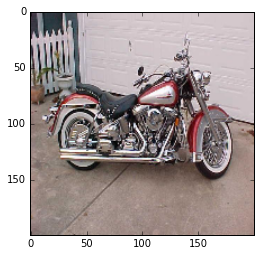

In [684]:
plt.imshow(im)

In [708]:
arr = (swap(Xtest[0]) * 255).astype(np.uint8)

In [701]:
from PIL import Image, ImageDraw, ImageFont

In [695]:
im = Image.fromarray(arr)

In [717]:
im.size

(200, 200)

In [696]:
draw = ImageDraw.Draw(im)

In [699]:
draw.rectangle([50,50,150,1000], outline=(0,255,0))

In [706]:
draw.text([40,40], "hello!")

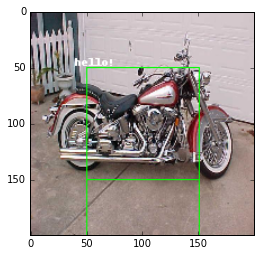

In [707]:
plt.imshow(im)

In [663]:
pred = np.copy(Xtest_out[N])
score = pred[[4,9]] * pred[-C:].max(keepdims=True)
score = score.flatten()
args = score.argsort()[::-1][:10]
preds = []
for i in range(args.size):
    idx = np.unravel_index(args[i], pred[[4,9]].shape)
    crd = pred[5*idx[0]:5*idx[0] + 4,idx[1], idx[2]]
    tmp = crd[[2,3]]
    tmp[tmp<1] = 0.5*tmp[tmp<1]**2
    tmp[tmp>=1] = np.abs(tmp[tmp>=1]) - 0.5
    crd[[2,3]] = tmp
    crd = crd.tolist()
    crd[0], crd[1] = crd[0] + np.float_(idx[2]) /S[1], crd[1] + np.float_(idx[1]) / S[0]
    crd.append(score[args[i]])
    preds.append(crd)
preds = np.asarray(preds)

In [660]:
nms(preds, .3)

/Users/colingaudreau/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:31: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 9 but corresponding boolean dimension is 8


array([[ 0.10364119,  0.11493982,  0.55785549,  0.52974772,  0.52931499]])

/Users/colingaudreau/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:31: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 9 but corresponding boolean dimension is 8
/Users/colingaudreau/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:18: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/colingaudreau/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:19: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/colingaudreau/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:20: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/colingaudreau/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:21: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


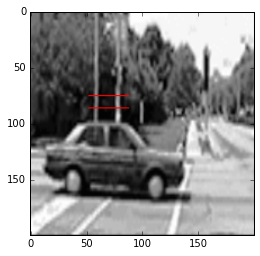

In [664]:
plt.imshow(draw_coord(swap(Xtest[N]), nms(preds, .3)[0], None))

In [ ]:
tmp = np.arange()

In [508]:
swap = lambda x: x.swapaxes(0,1).swapaxes(1,2)

In [549]:
N = int(Xtest.shape[0] * np.random.rand())
print N
a, b = draw_best(swap(Xtest[N]), Xtest_out[N], num = 5, thresh=.2)

12


['car', 'car', 'car', 'car', 'car']


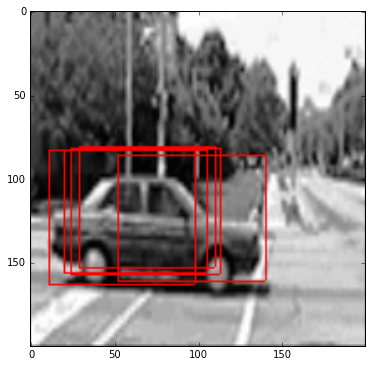

In [550]:
plt.figure(figsize=(6,6))
plt.imshow(a)
print b
# print '%s with class score: %.3f, objectness: %.3f' % (get_label_from_num(c.argmax()), c.max(), b)
# print c
# print d

In [443]:
im = swap(Xtest[int(np.random.rand()*Xtest.shape[0])])

In [ ]:
im2 = rgb2hsv(im)

In [ ]:
im2[:,:,1:] *= (1. + .3 * np.random.rand(1,1,2))

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(im)
plt.subplot(1,2,2)
plt.imshow(hsv2rgb(im2))

In [ ]:
im3 = hsv2rgb(im2)